In [1]:
import gurobipy as gp
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from utils.EnergyDataset import EnergyDataset

In [2]:
ds = EnergyDataset('../data/Final_Energy_dataset.csv','../data/price.csv', 47, 1, 'test')
dl = DataLoader(dataset=ds, batch_size=1, shuffle=False, num_workers=0)
dl_iter = iter(dl)

In [3]:
def dummy():
    for i in range(48):
        forecast = next(dl_iter)
    return forecast

In [4]:
timeslot = range(0, 48, 1)
LP = gp.Model('bess_opti')
solution = pd.DataFrame()
final_cost = torch.tensor(0.0)
priceFull = []

for i in range(363):
    load, price = dummy()
    load = load.flatten().numpy()
    price = price.flatten().numpy()
    priceFull.append(price)
    action = LP.addVars(timeslot, lb=-2.5, ub=2.5, vtype=gp.GRB.CONTINUOUS, name="action")
    soc = LP.addVars(range(0, 49, 1), vtype=gp.GRB.CONTINUOUS, name="soc")

    # Initial SOC constraint
    LP.addConstr(soc[0] == 0.0, "Initial_SOC")
    
    # Define SOC constraints over time
    for t in timeslot:
        LP.addConstr(soc[t + 1] == soc[t] + action[t], f"SOC_Update_{t}")
        LP.addConstr(soc[t + 1] >= 0, f"SOC_Lower_Bound_{t}")
        LP.addConstr(soc[t + 1] <= 10.0, f"SOC_Upper_Bound_{t}")

   # Define net load and objective function
    cost = gp.quicksum(price[t] * (load[t] + action[t]) for t in timeslot)
    LP.setObjective(cost, gp.GRB.MINIMIZE)
    
    # Optimize model
    LP.optimize()

    optimal_actions = [action[t].x for t in timeslot]
    final_objective_value = sum(price[t] * (load[t] + optimal_actions[t]) for t in timeslot)
    final_cost += final_objective_value

    print(f"Optimal cost: {final_cost}")


    local_solution = pd.DataFrame(index=range(0,48,1))
    local_solution['action'] = [action[t].x for t in timeslot]
    local_solution['soc'] = [soc[t].x for t in timeslot]
    solution = pd.concat([solution, local_solution], ignore_index=True)


Set parameter Username
Set parameter LicenseID to value 2597840
Academic license - for non-commercial use only - expires 2025-12-10
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 3700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 145 rows, 97 columns and 241 nonzeros
Model fingerprint: 0xffb604c5
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 4e-01]
  Bounds range     [3e+00, 3e+00]
  RHS range        [1e+01, 1e+01]
Presolve removed 98 rows and 2 columns
Presolve time: 0.01s
Presolved: 47 rows, 95 columns, 141 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.4654691e+01   1.086246e+03   0.000000e+00      0s
      24    4.9005881e-01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  

In [5]:
final_cost

tensor(-615.6373)

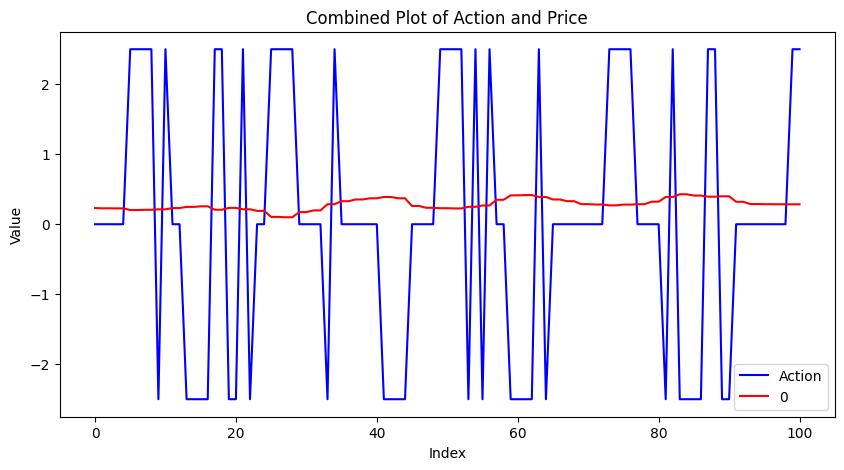

In [6]:
# Assuming solution['action'] and priceFull are defined
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the first data series
solution['action'].loc[0:100].plot(ax=ax, label='Action', color='blue')

# Plot the second data series
pd.DataFrame(np.array(priceFull).flatten()).loc[0:100].plot(ax=ax, label='Price', color='red')

# Add labels and title
ax.set_title('Combined Plot of Action and Price')
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.legend()

plt.show()


<Axes: >

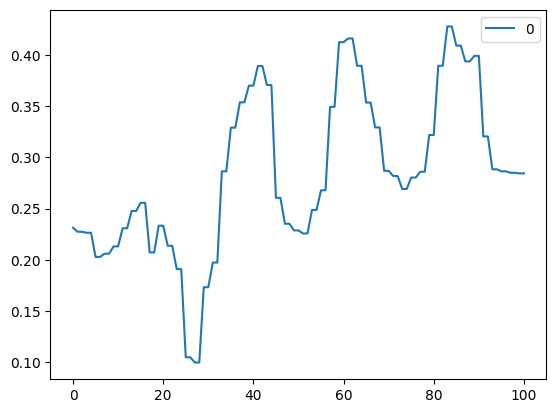

In [7]:
pd.DataFrame(np.array(priceFull).flatten()).loc[0:100].plot()
